In [8]:
import pandas as pd
import numpy as np
import tqdm # For getting progress information while the cell is running
# from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import _pickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 70)

with open("stock_pickle_full.pickle", 'rb') as fp:
    stocks_df = pickle.load(fp)

In [4]:
def setting_index(df):
    """
    Returns a sorted datetime index
    """
    df['Quarter end'] = pd.to_datetime(df['Quarter end'])
    df.set_index("Quarter end", inplace=True)
    return df.sort_index(ascending=True)
  
def class_creation(df, thres=3):
    """
    Creates classes of:
    - buy(1)
    - hold(2)
    - sell(0)
    
    Threshold can be changed to fit whatever price percentage change is desired
    """
    if df['Price high'] >= thres and df['Price low'] >= thres:
        # Buys
        return 1
    
    elif df['Price high'] <= -thres and df['Price low'] <= -thres:
        # Sells
        return 0
    
    else:
        # Holds
        return 2

In [ ]:
# Setting the index as the Date
for i in tqdm(stocks_df.keys()):
    stocks_df[i] = setting_index(stocks_df[i])
    
# Replacing all "None" values with NaN
for i in tqdm(stocks_df.keys()):
    stocks_df[i].replace("None", 0, inplace=True)
    
# Creating a new dictionary that contains the numerical values, then converting all values to numeric values
num_df = {}
for i in tqdm(stocks_df.keys()):
    num_df[i] = stocks_df[i].apply(pd.to_numeric)
    
# Replacing values with percent difference or change
pcnt_df = {}
for i in tqdm(num_df.keys()):
    pcnt_df[i] = num_df[i].pct_change(periods=1).apply(lambda x: x*100)
    
# Replacing infinite values with NaN
for i in tqdm(pcnt_df.keys()):
    pcnt_df[i] = pcnt_df[i].replace([np.inf, -np.inf], np.nan)
    
# Creating a new DataFrame that contains the class 'Decision' determining if a quarterly reports improvement is a buy, hold, or sell.
new_df = {}
for i in tqdm(pcnt_df.keys()):
    # Assigning the new DF
    new_df[i] = pcnt_df[i]
    
    # Creating the new column with the classes, shifted by -1 in order to know if the prices will increase/decrease in the next quarter.
    new_df[i]['Decision'] = new_df[i].apply(class_creation, axis=1).shift(-1)
    
# Excluding the first and last rows
for i in tqdm(new_df.keys()):
    new_df[i] = new_df[i][1:-1]
    
# Combining all stock DFs into one
big_df = pd.DataFrame()
for i in tqdm(pcnt_df.keys()):
    big_df = big_df.append(new_df[i], sort=False)
    
# Filling the NaNs with 0
big_df.fillna(0, inplace=True)

# Resetting the index because we no longer need the dates
big_df.reset_index(drop=True, inplace=True)

# Dropping the price related columns to prevent data leakage
big_df.drop(['Price', 'Price high', 'Price low'], 1, inplace=True)

# Exporting the final DataFrame
with open("main_df.pkl", 'wb') as fp:
    pickle.dump(big_df, fp)

Exploring the Data

In [6]:
with open("main_df.pkl", 'rb') as fp:
    final_df = pickle.load(fp)

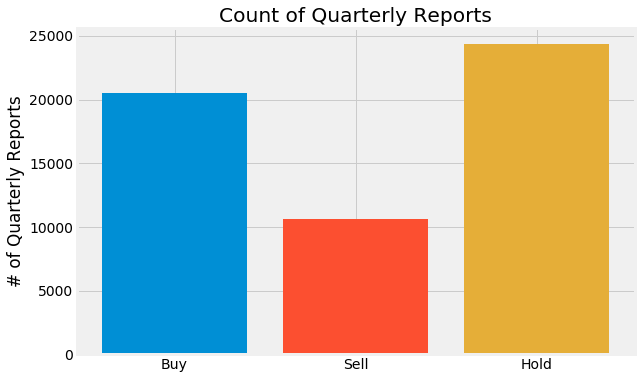

In [9]:
# Seperating each class into respective DataFrames
buy_df = final_df[final_df['Decision']==1].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
hold_df = final_df[final_df['Decision']==2].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)
sell_df = final_df[final_df['Decision']==0].loc[:, final_df.columns != 'Decision'].reset_index(drop=True)

# Visualizing in matplotlib
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# Plotting the count of each DataFrame of each class
plt.bar("Buy", buy_df.shape[0])
plt.bar("Sell", sell_df.shape[0])
plt.bar("Hold", hold_df.shape[0])

plt.ylabel('# of Quarterly Reports')
plt.title('Count of Quarterly Reports')
plt.show()